In [2]:
%load_ext rpy2.ipython

$\gamma_i$: relative risk; $q_i$: allel frequency

###Under H0: $\gamma = 1$

$q \sim Gamma(\rho_0, \nu_0)$    OR     $q \sim Gamma(\bar{q_0}\nu_0, \nu_0 )$ 

###Under H1:

$q \sim Gamma(\rho_1, \nu_1)$    OR    $q_i \sim Gamma(\bar{q_1}v_1, v_1)$

$\gamma_i \sim Gamma(\bar{\gamma}\beta, \beta)$

###Hyperparameters

$\phi_1 = (\bar{\gamma}, \beta, \bar{q_1}, v_1)$

$\phi_0 = (\bar{q_0}, v_0)$

###The rate of a specific type of mutation:

$c(\mu_{LoF}, \mu_{Mis3}) = c(0.074, 0.32)$  Table S3 (http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1003671)

###Mutation rate for each gene (in Methods)

Use gene length + base content as [De novo mutations revealed by whole-exome sequencing are strongly associated with autism](http://www.nature.com/nature/journal/v485/n7397/full/nature10945.html)

======
##Improvement in Nature 13772

###Two different prior distributions for $\gamma$: de novo and inherited variants

$\gamma_d \sim Gamma(\bar{\gamma_d} \beta_d, \beta_d) \quad \gamma \sim Gamma(\bar{\gamma} \beta, \beta) $

=> Change in BFs

### $B = \frac{P(x|H_1)}{P(x|H_0} = \frac{P(x_d|H_1) \times P(x_1, x_0 | H_1)}{P(x_d|H_0) \times P(x_1, x_0 | H_0)} = B_d \times B_i. $

In [49]:
%%R

source("scripts/TADA/TADA.R")

#################################################################
# Application of TADA
#################################################################

# Model parameters: two categories of mutations - LoF and mis3 mutations ("probably damaging" by PolyPhen2)
mu.frac <- c(0.074, 0.32) ##Mutation rates for specific category
#gamma.mean.dn <- c(20, 4.7)
gamma.mean.dn <- c(14, 2.33)
#beta.dn <- c(1,1)
beta.dn <- c(4.8, 2.325)


gamma.mean.CC <- c(2.8, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
#pi0 <- 0.94 # the fraction of non-risk genes
pi0 <- 1 - 0.07419

hyperpar

               [,1]     [,2]
gamma.mean.dn  14.0    2.330
beta.dn         4.8    2.325
gamma.mean.CC   2.8    1.000
beta.CC         4.0 1000.000
rho1            0.1    0.500
nu1           200.0  100.000
rho0            0.1    0.500
nu0           200.0  100.000


In [50]:
%%R
# ASC (Autism Sequencing Consortium) data
# The file name contains the sample size information
# The only relevant counts are dn.LoF and dn.mis3
#data <- read.csv("data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
#ntrio <- 2231  # number of trios
#ncase <- 1601  # number of cases
#nctrl <- 5397  # number of controls
#ntrans <- 1333 # number of subjects with transmission data
#N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

data <- read.csv("data/nature_aut_id_epi.merged.txt", header = TRUE, sep = " ")
#source("TADA/TADA.R")
ntrio <- 2270 + 32 + 0 + 2508 ##AUT
ntrio <- ntrio + 0 + 356 #add EPI
ntrio <- ntrio + 100 + 0 + 41 + 51 ##add ID samples
ncase <- 1601 #Only from AUT paper
nctrl <- 5397  #Only from AUT paper
ntrans <- 1298 ##Check this information, Only use transmitted information from AUT paper nature13772
#ntrans <- ntrio

N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)


print(head(data))

sum(unlist(N))

    Gene mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
1   A1BG 2.36e-05      0        0        1         0          0       0
2   A1CF 2.17e-05      0        1        2         1          1       0
3  A2LD1 6.09e-06      0        0        0         0          0       0
4    A2M 5.64e-05      0        1        5         1          0       1
5  A2ML1 5.70e-05      0        3       16         2          6       1
6 A4GALT 2.42e-05      0        0        2         1          0       0
  case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3     BF.dn         BF qvalue.dn
1         0         4          7           3 0.7641762 0.54953615 0.9308429
2         0         7          3           7 0.7799631 0.75499580 0.9294060
3         0         0          0           0 0.9322423 0.50824558 0.8592336
4         4        22          6           6 0.5305202 0.29674445 0.9388012
5         5        30          6          10 0.5270516 0.05155223 0.9388542
6         1         5          2        

###Total counts of variants

$N_d$: number of trios

$N_0 = N_{cn} + N_d \quad N_1 = N_{cs} + N_d$

$X_d \sim Pois(2\mu\lambda N_d) \quad X_1 \sim Pois(q\lambda N_1) \quad X_0 \sim Pois(q N_0)$

$X_0 = X_u + X_{cn}$: total number of LoF variants in the controls + the number of nontransmitted LoF variants

$X_1 = X_t + X_{cs}$: total number of LoF variants in the case + the number of transmitted LoF variants

###The likelihood function is the product of the three individual probabilities

$x = (x_d, x_1, x_0)$: count data for a gene to be tested

$P(x_d, x_1, x_0|q, \lambda) = Pois(x_d|2\mu\lambda N_d).Pois(x_1|q\lambda N_1) . Pois(x_0|qN_0)$

###






##Bayes factor for any gene:

$H_1: \gamma \neq 1 \quad vs. \quad H_0: \gamma = 1$

$\phi_1 = (\bar{\gamma}, \beta, \bar{q_1}, \nu_1)$: the prior parameters of $H_1$

$\phi_0 = (\bar{q_0}, \nu_0) $: the prior parameters of $H_0$

$P(x_i|H_0) = \int p(x_i|q_i, \gamma = 1)p(q_i|H_0)dq_i$

$P(x_i|H_1 = \int p(x_i|q_i, \gamma) p(q_i|H_1) p(\gamma_i |H_1) dq_i d\gamma_i$

Solve the marginal likelihood of all the data, as a function of the hyperparameters $(\phi_1, \phi_0)$

### $P(x|\phi_1, \phi_0) = \prod_{i=1}^{n}\left[ \pi P(x_i|H_1) + (1 - \pi)P(x_i|H_0)\right]$ 

$\pi$: the proportion of risk genes

Calculate the Bayes factor for each gene:

###$B_i = \frac{P(x_i|H_1)}{P(x_i|H_0)}$



###For multiple types of mutations (assumming that the data of each type of mutation are independent of each other)

$B = B_{LoF}[w.B_{Mis3} + (1 - w)]$

w = 0.55

In [51]:
%%R

# Running TADA
counts <- as.array(cbind(data$dn.LoF, ##Xd
                         data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, ##X1, X0
                         data$dn.mis3, 
                         data$case.mis3+data$trans.mis3, data$ctrl.mis3+data$ntrans.mis3))
head(counts)

     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    0    1    0    7    7
[2,]    0    2    3    0    3   14
[3,]    0    0    0    0    0    0
[4,]    0    2    5    1   10   28
[5,]    0    5   22    1   11   40
[6,]    0    1    2    0    3    6


In [52]:
%%R
#Running TADA
rs <- TADA(counts, N, data$mut.rate, mu.frac, hyperpar)
data$BF <- rs$BF.total


In [53]:
%%R
# Estimating p-values of BFs (this is optional and slow)
#rsp <- TADAp(counts, N, data$mut.rate, mu.frac, hyperpar, l=100)
#data$pval.TADA <- rsp$pval

##Use new method from nature13772

data$pval.TADA <- data$BF*(1 - pi0)/(pi0 + (1 - pi0)*data$BF)


In [54]:
%%R
# FDR estimation
data <- data[order(-data$BF),]
data$qvalue <- Bayesian.FDR(data$BF, pi0)$FDR
write.csv(data, "data/ext_TADA_results_usingNewPvalues_xem.csv", row.names=FALSE)



In [55]:
%%R
head(data)

         Gene mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
14230   SCN2A 7.40e-05      9        2        0         0          0      12
15819 SYNGAP1 6.55e-05      8        0        0         0          0       3
3312     CHD8 9.25e-05      7        4        0         0          0       2
14228   SCN1A 7.50e-05      4        1        0         0          0       7
3306     CHD2 7.02e-05      6        1        0         0          0       1
940    ARID1B 9.02e-05      6        0        0         0          0       1
      case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3        BF.dn           BF
14230         4        26          5           5 6.154767e+08 5.689429e+17
15819         3         6          4           2 2.315971e+08 6.624239e+09
3312          7        29          4           2 6.350230e+04 1.843809e+09
14228        11        16          9           5 9.478442e+00 7.524333e+07
3306          7         8          5           3 1.950725e+00 1.154755e+07
940        

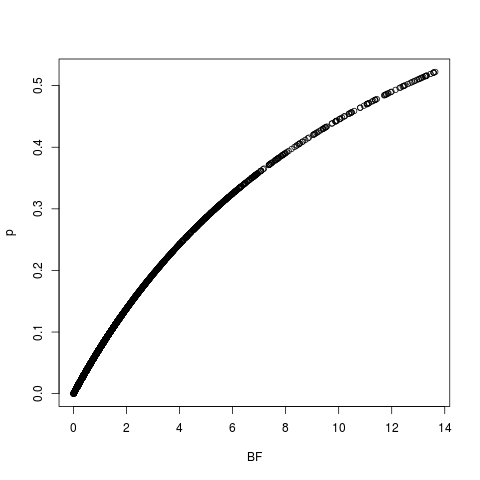

In [56]:
%%R
tempData <- data.frame(data$BF, data$pval.TADA)

tempData <- tempData[tempData[, 1] < quantile(tempData[, 1], 0.99), ]

plot(tempData[, 1], tempData[, 2], xlab = "BF", ylab = "p")

###Extract genes whose FDRs < 0.1

In [57]:
%%bash
cat data/ext_TADA_results.csv |awk -F"," '$(NF-1)<0.1'|\
    awk -F"," '{print $1}'|sed 's/"//g'|grep -v "Gene" |sort > data/list.genesWithNewPiFDR01.txt
    
cat data/list.genesWithNewPiFDR01.txt|wc -l
cat data/list.genesWithNewPiFDR01.txt|tr "\n" " "

32
ADNP ANK2 APH1A ARID1B ASH1L ASXL3 BCL11A BIRC6 CACNA2D3 CHD8 CUL3 DPP3 DYRK1A GABRB3 GALNTL4 GRIN2B KATNAL2 KIAA0182 MLL3 MYO9B NAA15 NR3C2 POGZ PTEN PYHIN1 RELN SCN2A SUV420H1 SYNGAP1 TBR1 TGM1 TRIO 

###Intersect this gene set with the 33 genes in AUT

In [17]:
%%bash
join -1 1 -2 1 data/list.genesWithNewPiFDR01.txt data/list.33genes.FDR0.1.txt|wc -l

25


####Test with known risk genes from three diseases: ASD + EPI + ID

In [43]:
%%R
hyperpar1 <- hyperpar
hyperpar1[3, 1] <- 2.3
hyperpar1
data1 <- data
head(data1$mut.rate)
print(hyperpar)
print(hyperpar1)

               [,1]     [,2]
gamma.mean.dn  14.0    2.330
beta.dn         4.8    2.325
gamma.mean.CC   2.3    1.000
beta.CC         4.0 1000.000
rho1            0.1    0.500
nu1           200.0  100.000
rho0            0.1    0.500
nu0           200.0  100.000
               [,1]     [,2]
gamma.mean.dn  14.0    2.330
beta.dn         4.8    2.325
gamma.mean.CC   2.3    1.000
beta.CC         4.0 1000.000
rho1            0.1    0.500
nu1           200.0  100.000
rho0            0.1    0.500
nu0           200.0  100.000


In [44]:
%%R
#Running TADA
rs1 <- TADA(counts, N, data1$mut.rate, mu.frac, hyperpar1)
data1$BF <- rs1$BF.total
# Estimating p-values of BFs (this is optional and slow)
#rsp1 <- TADAp(counts, N, data1$mut.rate, mu.frac, hyperpar1, l=100)
#data1$pval.TADA <- rsp1$pval

# FDR estimation
data1 <- data1[order(-data1$BF),]



In [45]:
%%R
head(data1, 1)

       Gene mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
15631 STAT4 2.61e-05      0        0        1         0          1       0
      case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3     BF.dn          BF
15631         3        15          1           5 0.7426887 2.21841e+18
      qvalue.dn    qvalue  pval.TADA
15631 0.9324757 0.9257113 0.02915459


In [47]:
%%R
print(head(data, 1))
data[grep("STAT4", data$Gene), ]

       Gene mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
14230 SCN2A  7.4e-05      9        2        0         0          0      12
      case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3     BF.dn           BF
14230         4        26          5           5 615476690 4.745777e+17
      qvalue.dn qvalue pval.TADA
14230  2.55e-08      0         1
       Gene mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
15631 STAT4 2.61e-05      0        0        1         0          1       0
      case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3     BF.dn        BF qvalue.dn
15631         3        15          1           5 0.7426887 0.3747428 0.9324757
         qvalue  pval.TADA
15631 0.9257113 0.02915459


In [48]:
%%R
data1$qvalue <- Bayesian.FDR(data1$BF, pi0)$FDR

head(data1[data1$qvalue < 0.1, ])

        Gene mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
15631  STAT4 2.61e-05      0        0        1         0          1       0
8972  LINGO1 3.98e-05      0        0        0         0          0       0
8220  KCNK12 1.41e-05      0        0        0         0          0       1
5108    ELL3 1.48e-05      0        3        8         1          1       0
6364  GARNL3 4.02e-05      0        2        1         0          0       0
11342 OR52B2 1.25e-05      0        2        3         3          1       0
      case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3     BF.dn           BF
15631         3        15          1           5 0.7426887 2.218410e+18
8972          0         9          1           1 0.6370376 1.116470e+10
8220          0         0          0           0 0.8508121 5.407493e+09
5108          0         6          4           1 0.8439596 3.030332e+08
6364          6        16          6           7 0.6342135 1.731686e+07
11342         0         6          0

In [40]:
%%R
print(cor(data$BF, data1$BF))
print(cor(data$qvalue, data1$qvalue))
#print(head(data, 3))
#print(head(data1, 3))




[1] 1
[1] 0.9991408


In [34]:
%%R
write.csv(data1, "data/ext_TADA_results_usingThreeGeneSets.csv", row.names=FALSE)

getwd()

[1] "/usr/data/extTADA"


In [27]:
%%bash
cat data/ext_TADA_results_usingThreeGeneSets.csv |awk -F"," '$(NF-1)<0.1'|\
    awk -F"," '{print $1}'|sed 's/"//g'|grep -v "Gene" |\
    sort > data/list.genesWithNewPiFDR01.usingThreeGeneSets.txt
    
cat data/list.genesWithNewPiFDR01.usingThreeGeneSets.txt|wc -l
cat data/list.genesWithNewPiFDR01.usingThreeGeneSets.txt|tr "\n" " "


104
ALAS1 ANKRD39 ANKRD49 ARL11 ARMC3 BHMT2 C12orf29 C22orf24 C5orf34 CAPRIN2 CASP1 CASP2 CDR2 CH25H CHN2 CHRNB1 CLK2 CLPS COX6B2 CSF1R CTDSP1 CYP4A11 DGKE DIS3L DSCR4 ELL3 EML1 EN1 ERV3-1 ESM1 FAM108A1 FAM189A2 FOXJ1 GARNL3 GPI GPR123 GRM4 HDAC9 HPSE2 ISM1 KCNK12 KCNMB4 KIF4B KRT14 KTN1 LINGO1 LRIT2 MED26 MIR205HG MRGPRF MRM1 MT1E MTX1 NPRL2 OPN1MW OR2M4 OR2Y1 OR52B2 OR6K2 OR8S1 PAN3 PCDHB12 PDPK1 PEAK1 PHGDH PIAS2 PPP2CB PRAMEF1 PRAP1 PTPRCAP PXDC1 RECK RHOH RIOK1 RLN1 SAGE1 SAPCD2 SCGB1A1 SETD8 SH3YL1 SLC29A4 SNAI2 SRCAP SRD5A2 ST6GALNAC5 STARD9 STAT4 STK11IP TAS2R9 TBCK TFDP1 THSD1 TIMM8B TP53I11 TSN UQCR11 VPS53 VPS54 XAGE3 ZBTB16 ZNF148 ZNF177 ZNF664-FAM101A ZNF706 

In [28]:
%%bash
join -1 1 -2 1 data/list.genesWithNewPiFDR01.usingThreeGeneSets.txt data/list.33genes.FDR0.1.txt|wc -l

0


In [22]:
#!gist -p Re_run_TADA_exTADA.ipynb

In [23]:
!gist -u https://gist.github.com/40eb110d8ac72b91d6e9 Re_run_TADA_exTADA.ipynb

https://gist.github.com/40eb110d8ac72b91d6e9
